In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import networkx as nx
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [3]:
pip install descartes

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


# reading and cleaning data

In [2]:
path = r"/Users/madi/Documents/Fall2021/535/Project" 
import os
data = DataFrame({})
for root, drectories, files in os.walk(path):
    for filename in files:
        data=data.append(DataFrame(pd.read_csv(os.path.join(root,filename))))

In [3]:
data.dropna(axis=0,how='any',subset=['Latitude','Longitude'],inplace=True) #removig nans
data=data[data['County']=='Wake'] #getting the data only for wake county

In [4]:
data=data.drop_duplicates(['Latitude','Longitude'], keep='first', inplace=False, ignore_index=False) #removing duplicates

In [5]:
#removing non important columns
data.drop(['StartTime (EST)','EndTime (EST)','RoadName','Suffix','Direction','CrossStreetName','CrossStreetSuffix','CrossStCommonName','MM From'], inplace=True, axis=1)

In [6]:
data.head()

,IncidentID,MM To,County,City,Division,Latitude,Longitude,StartLatitude,StartLongitude,EndLatitude,...,potentialhospitallatitude,potentialhospitallongitude,potentialhospitalcost,potentialhospitalcapacity,crashnumber,crashdateandtime,crashlatitude,crashlongitude,demand,pricepermile
10,505489.0,-999.0,Wake,In Cary,5.0,35.747747,-78.773745,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,505481.0,-999.0,Wake,Near Wake Forest,5.0,36.023102,-78.695207,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,505462.0,-999.0,Wake,In Raleigh,5.0,35.750838,-78.648966,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,505456.0,-999.0,Wake,In Raleigh,5.0,35.805339,-78.596841,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,505455.0,-999.0,Wake,In Raleigh,5.0,35.803746,-78.703765,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# K-mean Clustering for the accidents

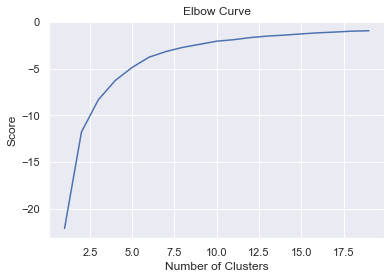

In [7]:
#performing the clustering
K_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = data[['Latitude','Longitude']]
X_axis = data[['Longitude','Latitude']]
score = [kmeans[i].fit(X_axis).score(X_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [8]:
kmeans = KMeans(n_clusters = 10, init ='k-means++') 
kmeans.fit(data[data.columns[5:7]]) # Compute k-means clustering.
data['cluster_label'] = kmeans.fit_predict(data[data.columns[5:7]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(data[data.columns[5:7]]) # Labels of each point
data.head(10)
labels= np.array(labels)

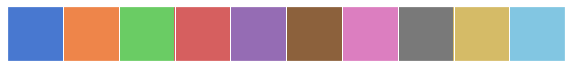

In [9]:
data.to_csv('clustered.csv', index=False) #writung the data in a csv file
sns.palplot(sns.color_palette("muted"))
rgb_values = sns.color_palette("husl", 8)

data.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

Text(0.5, 1.0, 'Clusters')

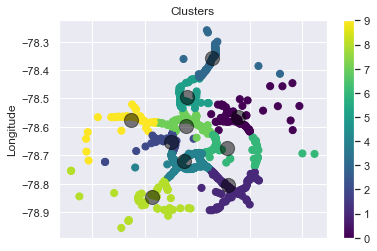

In [10]:
colors = np.array(np.arange(0,10)) #plotting the data clusters
color_map = dict(zip(colors, rgb_values))
data.plot.scatter(x = 'Latitude', y = 'Longitude', c= labels , s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title('Clusters')

In [12]:
centers = kmeans.cluster_centers_
centers

array([[ 35.87830461, -78.56414429],
       [ 35.85785774, -78.80569674],
       [ 35.75107743, -78.65317761],
       [ 35.82864624, -78.35874798],
       [ 35.7753989 , -78.71924753],
       [ 35.78023106, -78.49389576],
       [ 35.85652507, -78.67530545],
       [ 35.77845014, -78.59656114],
       [ 35.71486671, -78.84568296],
       [ 35.67401124, -78.57718778]])

# Calculating Circular Distance

In [13]:
#reading distance data
Data = pd.DataFrame(pd.read_csv(r'/Users/madi/Documents/Fall2021/535/Project/NEW754logisticsdata.xlsx - Sheet1.csv' ))
PotentialLocation = Data[['potentialhospitallatitude', 'potentialhospitallongitude']]
Existinglocation = Data[['existinghospitallatitude', 'existinghospitallongitude']]

In [14]:
#formula for calucalting the circular distance
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):


    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

    c = 2 * asin(sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    return(c * r)

In [15]:
distance_i_j=[]
for i in range(8):
    new= []
    new=[distance(PotentialLocation.loc[i].at["potentialhospitallatitude"],centers[j][0],PotentialLocation.loc[i].at["potentialhospitallongitude"],centers[j][1]) 
                 for j in range(len(centers))]
    distance_i_j.append(new)
distance_i_k=[]
for i in range(8):
    new= []
    new = [distance(Existinglocation.loc[i].at["existinghospitallatitude"],centers[j][0],Existinglocation.loc[i].at["existinghospitallongitude"],centers[j][1]) 
                 for j in range(len(centers))]
    distance_i_k.append(new)

# Implementing the model


In [16]:
I = [i for i in range(0,10)]

# Set of new spots for new hospitals
J = [j for j in range(0,8)]

# Set of hospitals that already existed
K = [k for k in range(0,8)]

# Set of (I,k)
IK = [(i,k) for i in I for k in K]

# Set of (I,j)
IJ = [(i,j) for i in I for j in J]

# Set of (j,k)
JK = [(j,k) for j in J for k in K]
# Gas Prices
gas_prices=2.86
# Demand
path = r'/Users/madi/Documents/Fall2021/535/clustered.csv'
DataClustered = pd.DataFrame(pd.read_csv(path))
h = DataClustered.groupby(['cluster_label'])['IncidentID'].count()


# capacity of potential hospitals
Capacity = Data['potentialhospitalcapacity']

# capacity of existed hospitals
Capacity_prime = Data['existinghospitalcapacity']

# Distance Potential

c_ij = {(i,j): gas_prices*distance_i_j[j][i] for (i,j) in IJ}


c_ik = {(i,k): gas_prices*distance_i_k[k][i] for (i,k) in IK}


# fixed cost of building
f = Data['potentialhospitalcost']

# fixed cost of maintaning a hospital
fprime = Data['existinghospitalfixedcost']


coveragedistance = 18

#coverage betweeen node i to node j
#a = {(i,j): int(d[i][j]<=18) for (i,j) in IJ}


# coverage percentage
alpha = 0.3

# number of new hospitals
p = 5

In [17]:
Capacity_prime[0:10]

0    50.0
1    50.0
2     5.0
3    32.0
4    50.0
5    38.0
6    20.0
7    48.0
8     NaN
9     NaN
Name: existinghospitalcapacity, dtype: float64

In [18]:
from gurobipy import Model, GRB, quicksum

In [19]:
mdl = Model('535 Project')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file /Users/madi/gurobi.lic


In [20]:
# Decision Variables

## if facility installed at node j
x = mdl.addVars(J, vtype=GRB.BINARY) 
## if facility kept at node j
xprim = mdl.addVars(K, vtype=GRB.BINARY) 
## if customer i is covered by one facility
y = mdl.addVars(IJ, vtype=GRB.CONTINUOUS)
yprim = mdl.addVars(IK, vtype=GRB.CONTINUOUS)

In [21]:
mdl.setObjective(quicksum(x[j]*f[j] for j in J)+quicksum(y[i,j]*c_ij[i,j] for i,j in IJ) + quicksum(yprim[i,k]*c_ik[i,k] for i,k in IK)
                , GRB.MINIMIZE)

In [22]:
mdl.addConstrs(quicksum(y[i,j]*h[i] for i in I) <= x[j]*Capacity[j] for j in J) #New

mdl.addConstrs(quicksum(yprim[i,k]*h[i] for i in I) <= Capacity_prime[k] for k in K) #Existing


mdl.addConstr(quicksum(x[j] for j in J)<=p) #mac number of new hospitals

mdl.addConstrs(y[i,j] <= 1 for i,j in IJ)
mdl.addConstrs(y[i,j] >= 0 for i,j in IJ)
mdl.addConstrs(yprim[i,k] <= 1 for i,k in IK)

mdl.addConstrs(yprim[i,k] >= 0 for i,k in IK)

mdl.addConstr(quicksum(y[i,j]*h[i] for i,j in IJ) +quicksum(yprim[i,k]*h[i] for i,k in IK) >= 
               alpha*quicksum(h[i] for i in I)) #demand satisfaction rate

<gurobi.Constr *Awaiting Model Update*>

In [23]:
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 338 rows, 176 columns and 656 nonzeros
Model fingerprint: 0x36585576
Variable types: 160 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 328 rows and 157 columns
Presolve time: 0.01s
Presolved: 10 rows, 19 columns, 35 nonzeros
Variable types: 11 continuous, 8 integer (8 binary)

Root relaxation: objective 3.300941e+02, 10 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  330.09410    0    1          -  330.09410      -     -    0s
H    0     0                     385.8362585  330.09410  14.4%     -    0s
     0     0  331.78067    0    

In [24]:
x

{0: <gurobi.Var C0 (value 1.0)>,
 1: <gurobi.Var C1 (value -0.0)>,
 2: <gurobi.Var C2 (value -0.0)>,
 3: <gurobi.Var C3 (value -0.0)>,
 4: <gurobi.Var C4 (value 1.0)>,
 5: <gurobi.Var C5 (value 1.0)>,
 6: <gurobi.Var C6 (value 1.0)>,
 7: <gurobi.Var C7 (value 1.0)>}

In [25]:
centeral = [i[0] for i in centers]
centerlong = [i[1] for i in centers]

# Visualizing the result

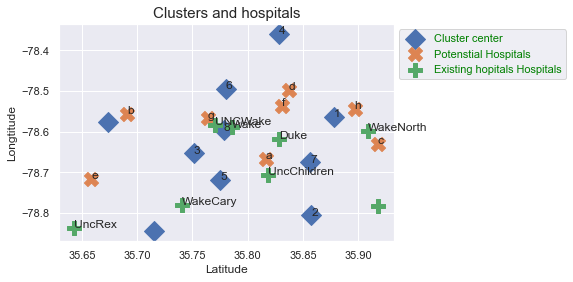

In [36]:
# plotiing the centers potential and new hospitals
colors = np.random.rand(10)
plt.scatter(centeral,centerlong,s=200, marker="D", label = 'Cluster center')
plt.scatter(PotentialLocation['potentialhospitallatitude'],PotentialLocation['potentialhospitallongitude'], s=200,marker = "X",label = 'Potenstial Hospitals')
plt.scatter(Existinglocation['existinghospitallatitude'],Existinglocation['existinghospitallongitude'], s=200,marker = "P", label = 'Existing hopitals Hospitals')
s1=['1','2','3','4','5','6','7','8'] #plot label
s2=['a','b','c','d','e','f','g','h']#plot label
s3=['WakeNorth','Wake','UNCWake','Duke', 'WakeCary','UncRex',
                         'UncChildren'] #plot label
plt.xlabel("Latitude")
plt.ylabel("Longtitude")
plt.title("Clusters and hospitals",fontsize=15)
plt.legend(loc=2,bbox_to_anchor=(1, 1),labelcolor= 'green') # chngeing color of different points
for i, label in enumerate(s2):
    plt.text(PotentialLocation['potentialhospitallatitude'][i], PotentialLocation['potentialhospitallongitude'][i],label)
for i, label in enumerate(s3):
    plt.text(Existinglocation['existinghospitallatitude'][i], Existinglocation['existinghospitallongitude'][i],label)
for i, label in enumerate(s1):
    plt.text(centeral[i], centerlong[i],label)

<AxesSubplot:>

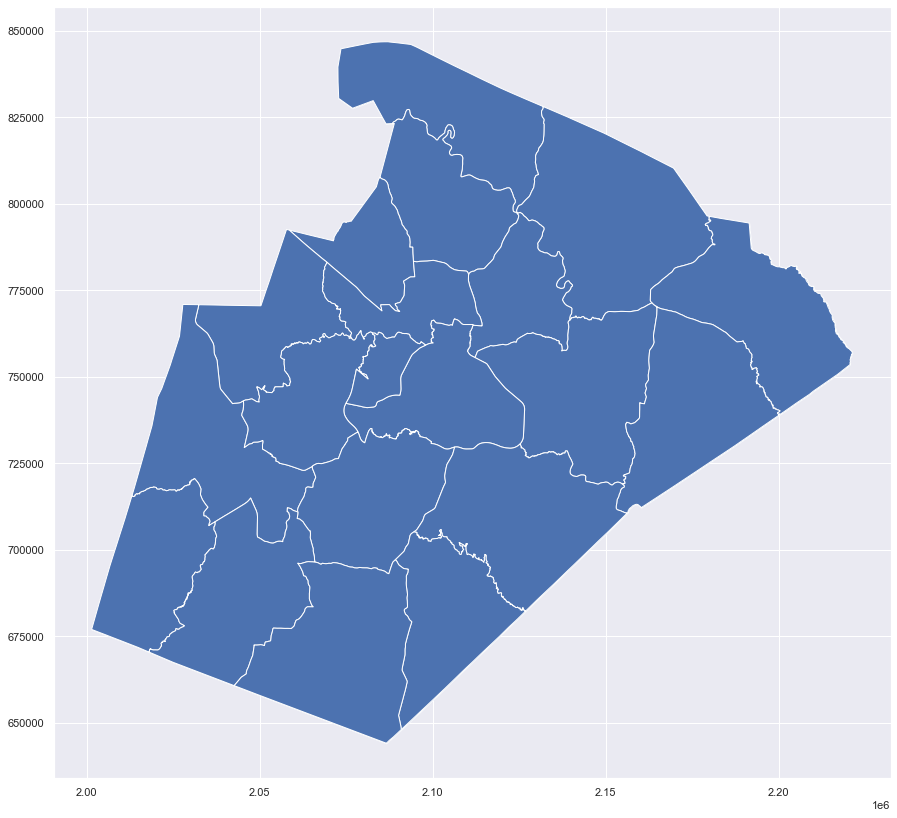

In [38]:
Wake = gpd.read_file('/Users/madi/Documents/Fall2021/535/Wake_County_Line.shp')
town= gpd.read_file('/Users/madi/Documents/Fall2021/535/Townships-shp/01364030-cddb-4670-a095-4e15193665872020330-1-d3s0ym.2yd2o.shp')
fig,ax = plt.subplots(figsize = (15,15))
Wake.plot(ax = ax) #reading the wake county shape
town.plot(ax = ax)

In [39]:
center1=[[2.067876589785, 2.16556565564678, 2.054345674675,2.087679676543,2.13241968553876,2.179878967453,2.098321345697,2.19356457678],
               [77.89098,73.7379766556,68.764598675434,80.54977865675454,77.540896545,78.9877876785434,70.87923546576,74.764897648765]]
for i in range(8):
    center1[0][i]=center1[0][i]*1000000
    center1[1][i]=center1[1][i]*10000
center = pd.DataFrame(center1[0])
center[1]=center1[1]
center # changig the data into us foot from latitude and longitude

,0,1
0,2.067877e+06,778909.800000
1,2.165566e+06,737379.766556
2,2.054346e+06,687645.986754
3,2.087680e+06,805497.786568
4,2.132420e+06,775408.965450
5,2.179879e+06,789877.876785
6,2.098321e+06,708792.354658
7,2.193565e+06,747648.976488


In [40]:
geometrycenter = [Point (xy) for xy in zip( center[0], center[1]) ]
geometrycenter[:3] #turning data into points

In [41]:
geodfcenter = gpd.GeoDataFrame(center,crs = "EPSG:2264", geometry = geometrycenter) 
geodfcenter.head() #turning data into points

,0,1,geometry
0,2.067877e+06,778909.800000,POINT (2067876.590 778909.800)
1,2.165566e+06,737379.766556,POINT (2165565.656 737379.767)
2,2.054346e+06,687645.986754,POINT (2054345.675 687645.987)
3,2.087680e+06,805497.786568,POINT (2087679.677 805497.787)
4,2.132420e+06,775408.965450,POINT (2132419.686 775408.965)


Text(0.5, 1.0, 'Wake County')

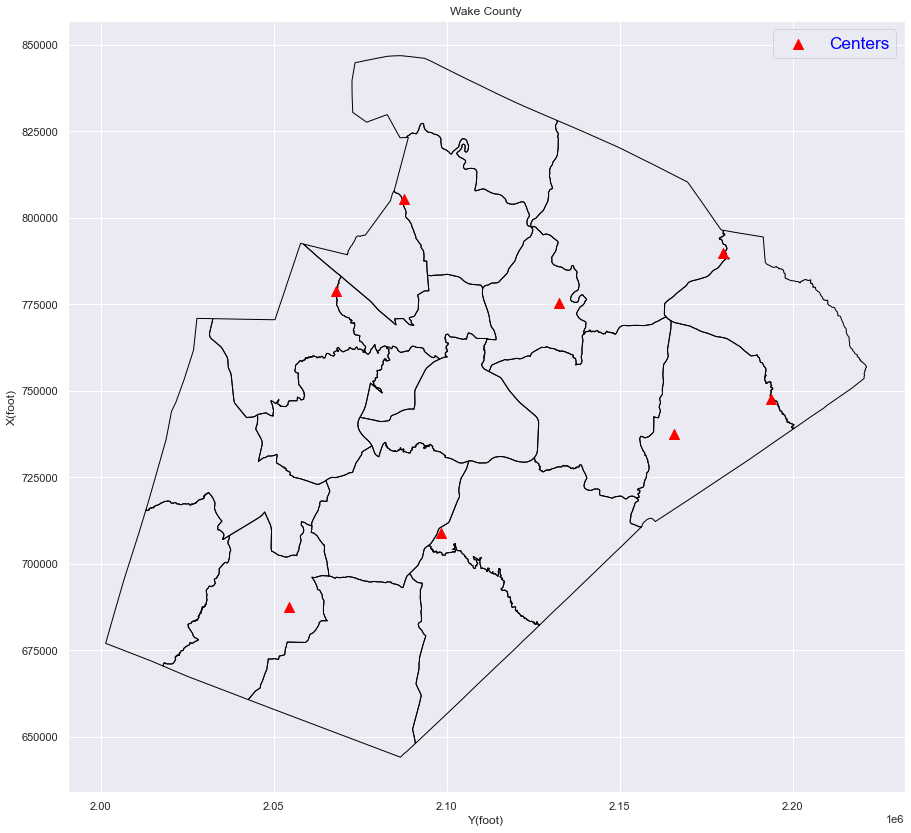

In [46]:
#plottting the wake county and the xenters in the wake county
fig,ax = plt.subplots(figsize = (15,15))
town.plot(ax=ax,facecolor="none", edgecolor="black")
geodfcenter.plot(ax = ax, markersize = 100, color = 'red', marker="^", label ='Centers')
plt.legend(labelcolor='blue', fontsize='x-large')
plt.xlabel('Y(foot)')
plt.ylabel('X(foot)')
plt.title('Wake County') 

In [50]:
# turnign the data into us foot
generatedadat1=[[2.0568789785, 2.0956576678, 2.12656684,2.1479676543,2.18968553876,2.139878967453,2.06321345697,2.07356457678],
               [67.899098,74.879766556,75.98675434,77.8977865675454,74.90896545,80.8876785434,74.923546576,76.98897648765]]
for i in range(8):
    generatedadat1[0][i]=generatedadat1[0][i]*1000000
    generatedadat1[1][i]=generatedadat1[1][i]*10000
generatedadat = pd.DataFrame(generatedadat1[0])
generatedadat[1]=generatedadat1[1]
generatedadat 

,0,1
0,2.056879e+06,678990.980000
1,2.095658e+06,748797.665560
2,2.126567e+06,759867.543400
3,2.147968e+06,778977.865675
4,2.189686e+06,749089.654500
5,2.139879e+06,808876.785434
6,2.063213e+06,749235.465760
7,2.073565e+06,769889.764877


In [51]:
geometry = [Point (xy) for xy in zip( generatedadat[0], generatedadat[1]) ]
geometry[:3] # r=turning data into points

In [52]:
geodf = gpd.GeoDataFrame(generatedadat,crs = "EPSG:2264", geometry = geometry) 
geodf.head() r=turning data into points

,0,1,geometry
0,2.056879e+06,678990.980000,POINT (2056878.978 678990.980)
1,2.095658e+06,748797.665560,POINT (2095657.668 748797.666)
2,2.126567e+06,759867.543400,POINT (2126566.840 759867.543)
3,2.147968e+06,778977.865675,POINT (2147967.654 778977.866)
4,2.189686e+06,749089.654500,POINT (2189685.539 749089.654)


In [53]:
# turnign the data into us foot
newhos1=[[2.03876589785, 2.0556565564678, 2.08345674675,2.1179676543,2.141968553876,2.179878967453,2.078321345697,2.22356457678],
               [70.899098,76.879766556,67.34598675434,83.8977865675454,71.50896545,74.877876785434,74.6923546576,76.768897648765]]
for i in range(8):
    newhos1[0][i]=newhos1[0][i]*1000000
    newhos1[1][i]=newhos1[1][i]*10000
newhos = pd.DataFrame(newhos1[0])
newhos[1]=newhos1[1]
newhos

,0,1
0,2.038766e+06,708990.980000
1,2.055657e+06,768797.665560
2,2.083457e+06,673459.867543
3,2.117968e+06,838977.865675
4,2.141969e+06,715089.654500
5,2.179879e+06,748778.767854
6,2.078321e+06,746923.546576
7,2.223565e+06,767688.976488


In [54]:
geometry2 = [Point (xy) for xy in zip( newhos[0], newhos[1]) ]
geometry2[:3]
geodf2 = gpd.GeoDataFrame(newhos,crs = "EPSG:2264", geometry = geometry2) 
geodf2.head() # turnung data into points

,0,1,geometry
0,2.038766e+06,708990.980000,POINT (2038765.898 708990.980)
1,2.055657e+06,768797.665560,POINT (2055656.556 768797.666)
2,2.083457e+06,673459.867543,POINT (2083456.747 673459.868)
3,2.117968e+06,838977.865675,POINT (2117967.654 838977.866)
4,2.141969e+06,715089.654500,POINT (2141968.554 715089.655)


Text(0.5, 1.0, 'Wake County')

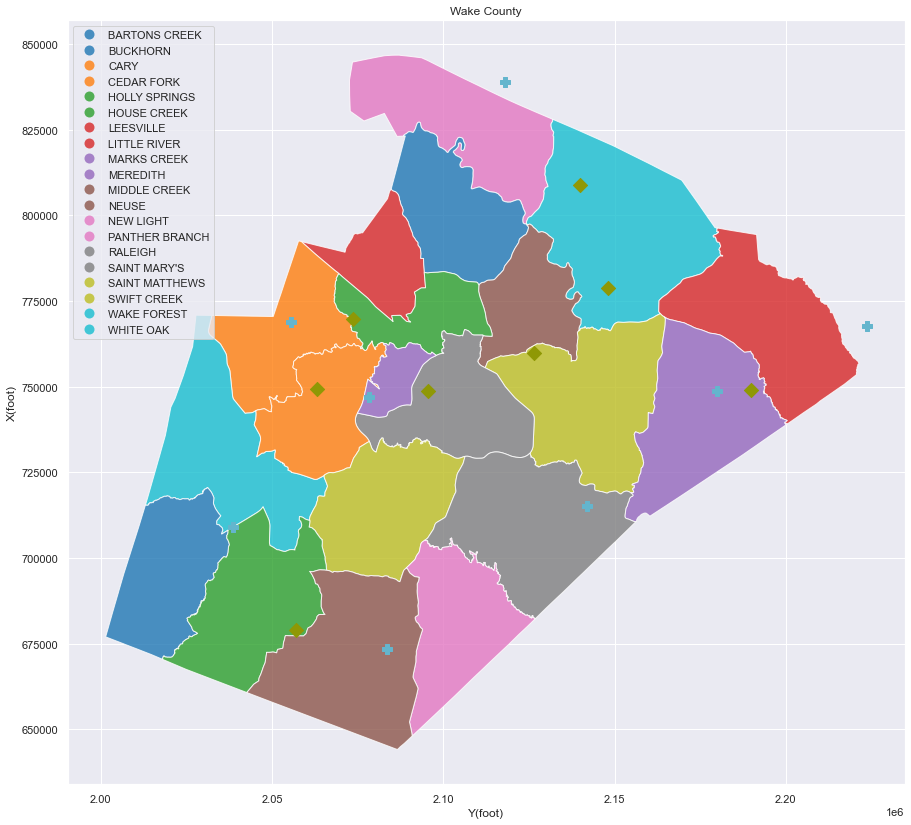

In [60]:
fig,ax = plt.subplots(figsize = (15,15))
town.plot(ax = ax, alpha = 0.8, column = 'NAME', legend = True)
geodf.plot(ax = ax, markersize = 100, color = '#8f9805', marker='D',label='Potential hopitals')
geodf2.plot(ax = ax, markersize = 100, color = 'c', marker="P", label='Existing hospitals')
plt.xlabel('Y(foot)')
plt.ylabel('X(foot)')
plt.title('Wake County')  

# Graphs

In [219]:
Potential = nx.Graph()

In [220]:
Potential.add_nodes_from([('a', {"color": "red"}),('b', {"color": "red"}),('c', {"color": "red"}),
                         ('d', {"color": "red"}),('e', {"color": "red"}),('f', {"color": "red"}),
                         ('g', {"color": "red"}),('h', {"color": "red"})])

#building the grpah

In [221]:
Existing = nx.Graph()

In [222]:
#building the grpah
Existing.add_nodes_from([('wakemednorthhospital', {"color": "blue"}),('wakemed', {"color": "blue"}),('uncwakebrookhospital', {"color": "blue"}),
                         ('dukehospitalraleigh', {"color": "blue"}),('wakemedcaryhospital', {"color": "blue"}),('uncrexhospital', {"color": "blue"}),
                         ('unchospitalschildrensspecialty', {"color": "blue"})])

In [223]:
Centers = nx.Graph()

In [224]:
#building the grpah
Centers.add_nodes_from([(1, {"color": "green"}),(2, {"color": "green"}),(3, {"color": "green"}),
                         (4, {"color": "green"}),(5, {"color": "green"}),(6, {"color": "green"}),
                         (7, {"color": "green"}),(8, {"color": "green"})])

In [225]:
# merging all the graphs
Allnodes = nx.Graph()
Allnodes.add_nodes_from(Potential)
Allnodes.add_nodes_from(Existing)
Allnodes.add_nodes_from(Centers)

In [226]:
Allnodes.add_edges_from([(1, 'a'), (1, 'uncrexhospital'),(1,'e'),(2,'g'),(2,'wakemed'),(3,'a'),(3,'wakemedcaryhospital'),(3,'uncrexhospital'),
                        (4,'dukehospitalraleigh'),(4,'unchospitalschildrensspecialty'),(4,'wakemedbriercreekhealthplex'),(5,'d'),(5,'b'),
                        (6,'uncwakebrookhospital'),(6,'unchospitalschildrensspecialty'),(6,'dukehospitalraleigh'),(7,'a'),(7,'wakemed'), (8,'dukehospitalraleigh'),(8,'g'),(8,'f')])

In [36]:
Allnodes = nx.Graph()

In [37]:
Allnodes.add_nodes_from([(1, {"color": "green"}),(2, {"color": "green"}),(3, {"color": "green"}),
                         (4, {"color": "green"}),(5, {"color": "green"}),(6, {"color": "green"}),
                         (7, {"color": "green"}),(8, {"color": "green"}),('wakemednorthhospital', {"color": "blue"}),('wakemed', {"color": "blue"}),('uncwakebrookhospital', {"color": "blue"}),
                         ('dukehospitalraleigh', {"color": "blue"}),('wakemedcaryhospital', {"color": "blue"}),('uncrexhospital', {"color": "blue"}),
                         ('unchospitalschildrensspecialty', {"color": "blue"}),('a', {"color": "red"}),('b', {"color": "red"}),('c', {"color": "red"}),
                         ('d', {"color": "red"}),('e', {"color": "red"}),('f', {"color": "red"}),
                         ('g', {"color": "red"}),('h', {"color": "red"})])

In [38]:
Allnodes.add_edges_from([(1, 'a'), (1, 'uncrexhospital'),(1,'f'),(2,'b'),(2,'wakemed'),(3,'a'),(3,'wakemedcaryhospital'),(3,'uncrexhospital'),
                        (4,'dukehospitalraleigh'),(4,'unchospitalschildrensspecialty'),(4,'wakemedbriercreekhealthplex'),(5,'d'),(5,'b'),(5,'wakemednorthhospital'),
                        (6,'uncwakebrookhospital'),(6,'unchospitalschildrensspecialty'),(6,'dukehospitalraleigh'),(7,'a'),(7,'wakemed'), (8,'dukehospitalraleigh'),(8,'b'),(8,'f')])
# definfin the edges

In [247]:
!pip install -U networkx # for graphs to be shown these libraries must be updated

In [ ]:
!pip install -U matplotlib

In [ ]:
!pip install -U decorator

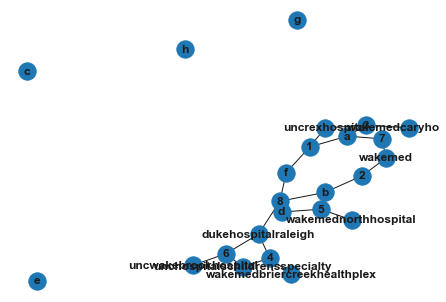

In [243]:
nx.draw(Allnodes, with_labels=True, font_weight='bold')

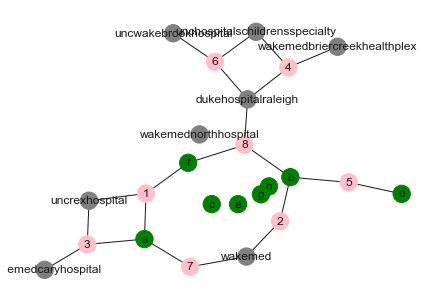

In [239]:
color_map = []
for node in Allnodes:
    if node in [1, 2, 3, 4,5,6,7,8]:
        color_map.append('pink')
    elif node in ['a','b','c','d','e','f','g','h']: 
        color_map.append('green')  
    else:
        color_map.append('gray')  
nx.draw(Allnodes, pos = nx.kamada_kawai_layout(Allnodes),node_color=color_map, with_labels=True)
plt.show()

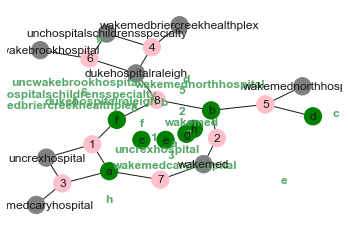

In [253]:
label = nx.draw_networkx_labels(Allnodes, pos=nx.spring_layout(Allnodes), font_size=12, 
                     font_color='g', font_family='sans-serif', font_weight='bold', alpha=None, 
                     bbox=None, horizontalalignment='center', verticalalignment='center', ax=None, clip_on=True)
nx.draw(Allnodes, pos = nx.kamada_kawai_layout(Allnodes),label = label, node_color=color_map, with_labels=True)
plt.show()

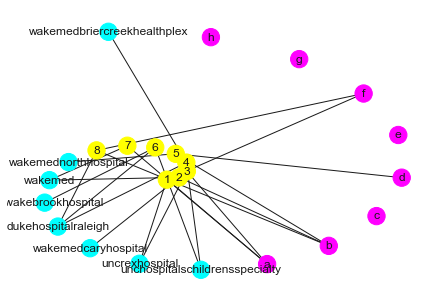

In [40]:
color_map = []
for node in Allnodes:
    if node in [1, 2, 3, 4,5,6,7,8]:
        color_map.append('yellow')
    elif node in ['a','b','c','d','e','f','g','h']: 
        color_map.append('magenta')  
    else:
        color_map.append('cyan')  

nx.draw(Allnodes, pos = nx.spiral_layout(Allnodes),node_color=color_map, with_labels=True)
plt.show()